# PSD

Plot the PSD of the data during the retention intervall per eccentricity. 
This is a figure for the supplementary material. 

20222 -- Felix KLotzsche

In [4]:
# load libs:
from collections import defaultdict
from os import path as op
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from multiprocessing import Pool
from functools import partial

import pandas as pd
import seaborn as sns

import mne

from library import config, helpers

In [8]:

def get_epos(subID, epo_part, signaltype, condition, event_dict):
    """Load and return epochs of EEG data for a given subject and experimental condition.

    Parameters
    ----------
    subID : str
        The subject number.
    epo_part : str
        The part of the epoch to load.
    signaltype : str
        The type of signal to load.
    condition : str
        The experimental condition.
    event_dict : dict
        A dictionary mapping experimental conditions to event codes.

    Returns
    -------
    mne.Epochs
        The epochs of the EEG data.
    """
    if signaltype == 'uncollapsed':
        fname = op.join(config.path_rejepo, subID + '-' + epo_part +
                        '-postica-rejepo' + '-epo.fif')
    elif signaltype in ['collapsed', 'difference']:
        fname = op.join(config.paths['03_preproc-pooled'], epo_part, signaltype,
                        '-'.join([subID, epo_part, signaltype, 'epo.fif']))
    else:
        raise ValueError(f'Invalid value for "signaltype": {signaltype}')
    epos = mne.read_epochs(fname, verbose=False)
    epos = epos.pick_types(eeg=True)
    uppers = [letter.isupper() for letter in condition]
    if (np.sum(uppers) > 2):
        cond_1 = condition[:np.where(uppers)[0][2]]
        cond_2 = condition[np.where(uppers)[0][2]:]
        selection = epos[event_dict[cond_1]][event_dict[cond_2]]
    else:
        selection = epos[event_dict[condition]]
    return(selection)


def load_data_calc_psd(sub, cond, picks):
    """Load EEG data for a given subject, condition, and channel picks, and calculate the power spectral density (PSD) of the data.

    Parameters
    ----------
    sub : int
        The subject number.
    cond : str
        The experimental condition.
    picks : list of str
        The channel picks.

    Returns
    -------
    tuple
        A tuple containing the power spectral density values and the corresponding frequencies.
    """

    he = get_epos(sub, 'stimon', 'collapsed', cond, config.event_dict)
    ppsd = mne.time_frequency.psd_welch(he.copy().pick(picks),
                                        fmin=0.01,fmax=45,
                                        tmin=0.2, tmax=2.2,
                                        average='mean',
                                        n_fft=512,
                                        verbose=False)
    return(ppsd)

In [9]:
# setup

# Globally set font:
plt.rcParams["font.family"] = config.plt_fontname
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.size'] = 7
plt.rcParams["legend.fontsize"] = 7

In [10]:

sub_list = np.setdiff1d(np.arange(1, 28), config.ids_missing_subjects +
                        config.ids_excluded_subjects)               
sub_list_str = ['VME_S%02d' % sub for sub in sub_list]

event_dict = config.event_dict

psd_per_cond = defaultdict(list)

# Load the epochs:
for cond in ('LoadLow', 'LoadHigh', 'EccS', 'EccM', 'EccL'):
    with Pool(len(sub_list_str)) as p:
        psd_per_cond[cond] = p.map(
            partial(
                load_data_calc_psd,
                cond=cond,
                picks=config.chans_CDA_all,
            ),
            [s for s in sub_list_str]
        )

# put the data into a dataframe for plotting:
df_overall = pd.DataFrame()
for cond in ('EccS', 'EccM', 'EccL'):
    freqs = psd_per_cond[cond][0][1]
    for pick, idx in zip(('Contra', 'Ipsi'), (range(5), range(5, 10))):
        data = [p[0].mean(axis=0)[idx, :] for p in psd_per_cond[cond]]
        data = np.array(data).mean(axis=(1))
        df = pd.DataFrame(data).melt(var_name='freq', value_name='pwr')
        df['subidx'] = np.repeat(range(21), len(freqs))
        df['cond'] = config.labels[cond]
        df['pick'] = pick
        df['pwr_db'] = 10 * np.log10(df.pwr)
        df_overall = pd.concat([df_overall, df])

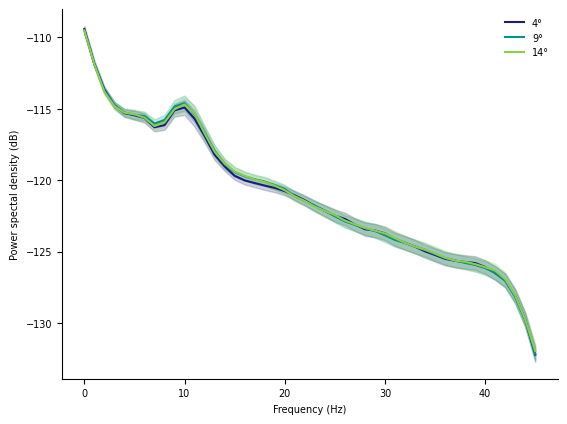

In [12]:
# Plot it:
fig, ax = plt.subplots()
sns.lineplot(data=df_overall, x='freq', y='pwr_db', hue='cond', errorbar='se', ax=ax, palette=config.colors)
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Power spectal density (dB)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# remove legend title
ax.legend().set_title(None)
ax.legend().set_frame_on(False)


# Save it: 
fpath = op.join(config.paths['plots'], 'Else')
helpers.chkmk_dir(fpath)
fname = op.join(fpath, 'PSD_per_ecc.pdf')
fig.savefig(fname, bbox_inches="tight")